<H1> Notebook to verify the calculations of our simulator </H1>

## Importing required libraries

In [1]:
# importaing standard libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import freqs,periodogram,cheby1
import numpy as np

In [2]:
# import quantum libraries
import qutip
from itertools import product
from numpy import array, kron
from qmldataset import pauli_operators, create_custom_simulator, run_experiment

2021-09-26 16:34:01.309496: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Step 1: Create a simulator

We supply the parameters and create a simulator. Here we will create a 1-qubit experiment with Control on X-Axis, Type 1 noise on Z-Axis

In [3]:
dimension = 2
evolution_time = 1
num_time_steps = 1024
omega = 12
dynamic_operators = [0.5*pauli_operators[1]]
static_operators = [0.5*pauli_operators[3]*omega]
noise_operators = [0.5*pauli_operators[3]]
measurement_operators = pauli_operators[1:]
initial_states = [
    np.array([[0.5, 0.5], [0.5, 0.5]]), np.array([[0.5, -0.5], [-0.5, 0.5]]),
    np.array([[0.5, -0.5j], [0.5j, 0.5]]), np.array([[0.5, 0.5j], [-0.5j, 0.5]]),
    np.array([[1, 0], [0, 0]]), np.array([[0, 0], [0, 1]])
]
num_realizations = 200
num_pulses = 5
noise_profile = ['Type 1']
distortion = True

simulator_with_distortion = create_custom_simulator(
    evolution_time=evolution_time,
    num_time_steps=num_time_steps,
    dimension=dimension,
    dynamic_operators=dynamic_operators,
    static_operators=static_operators,
    noise_operators=noise_operators,
    measurement_operators=measurement_operators,
    initial_states=initial_states,
    num_realizations=num_realizations,
    num_pulses=num_pulses,
    noise_profile=noise_profile,
    distortion=distortion,
    pulse_shape="Square"
)

2021-09-26 16:34:05.687838: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-26 16:34:05.689143: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-26 16:34:05.737996: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 16:34:05.738543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0e:00.0 name: GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.43GHz coreCount: 6 deviceMemorySize: 3.94GiB deviceMemoryBandwidth: 104.43GiB/s
2021-09-26 16:34:05.738610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-26 16:34:05.741933: I tensorflow/stream_executor/platform/default/

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
signal_generator (SignalGenerat ((None, 5, 3), (None 0           input_1[0][0]                    
__________________________________________________________________________________________________
lti_layer (LTILayer)            (None, 1024, 1, 1)   0           signal_generator[0][1]           
__________________________________________________________________________________________________
H0 (HamiltonianConstruction)    (None, 1024, 1, 2, 2 0           lti_layer[0][0]                  
______________________________________________________________________________________________

## Now we run a single experiment

The experiment will produce a result by simulating `num_realizations` number of noise realizations.

In [4]:
experiment_result = run_experiment(simulator=simulator_with_distortion)

2021-09-26 16:34:09.738690: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-26 16:34:09.761987: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3094175000 Hz
2021-09-26 16:34:13.227801: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-26 16:34:13.612214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-26 16:34:13.642600: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10
2021-09-26 16:34:13.917894: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x5646df642640
2021-09-26 16:34:13.918105: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcusolver.so.10
2021-09-26 16:34:14.231

1/1 [==============================] - 8s 8s/step


## Once run, let us read the experiment outcome

[[-20.345783     0.12233578   0.1       ]
 [ 58.95591      0.27380085   0.1       ]
 [ 38.14025      0.4457677    0.1       ]
 [ 29.669308     0.61551726   0.1       ]
 [-74.14498      0.7660476    0.1       ]]


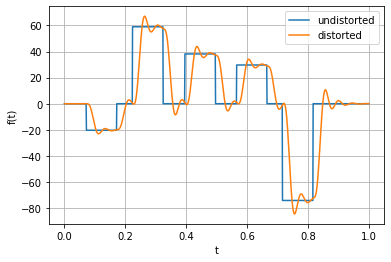

In [5]:
# plot the pulse
plt.figure()
num_controls = len(experiment_result["sim_parameters"]["dynamic_operators"])
for idx in range(num_controls):
    plt.subplot(num_controls , 1, idx+1 )
    plt.plot(experiment_result["time_range"], experiment_result["pulses"][:,0,idx], label="undistorted")
    plt.plot(experiment_result["time_range"], experiment_result["distorted_pulses"][:,0,idx], label="distorted")
    plt.xlabel('t')
    plt.ylabel('f(t)')
    plt.grid()
    plt.legend()
print(experiment_result["pulse_parameters"])

## Display the distortion if exists

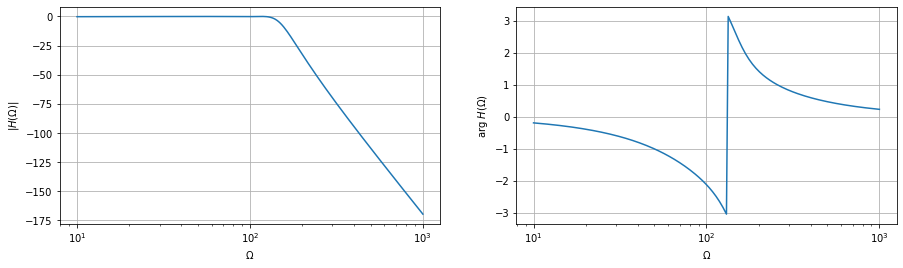

In [6]:
if distortion:
    # display distortion filter if exists
    distortion = cheby1(4,0.1,2*np.pi*20, analog=True)
    # evaluate frequency response of the filter
    w, Hw = freqs(distortion[0], distortion[1])
    plt.figure(figsize=[15,4])
    plt.subplot(1,2,1)
    plt.semilogx(w, 20*np.log(np.abs(Hw)))
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'$|H(\Omega)|$')
    plt.grid()
    plt.subplot(1,2,2)
    plt.semilogx(w, np.angle(Hw))
    plt.xlabel(r'$\Omega$')
    plt.ylabel(r'arg $H(\Omega)$')
    plt.grid()

## Display the noise

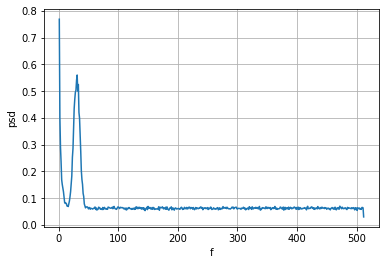

In [7]:
# display noise if exists
for idx_profile,profile in enumerate(experiment_result["sim_parameters"]["noise_profile"]): 
    if profile in ['Type 2','Type 3','Type 4'] or (profile=='Type 6' and p==0): 
        # estimate the correlation matrix of the noise
        correlation = 0
        for k in range(experiment_result["sim_parameters"]["num_realizations"]):
            correlation = correlation + experiment_result["noise"][:,k:k+1,idx_profile]@experiment_result["noise"][:,k:k+1,idx_profile].T
        correlation = correlation/data["sim_parameters"]["num_realizations"]
        # plot correlation matrix
        plt.figure()
        plt.matshow(correlation,0)
        plt.colorbar()
        p = 0
    elif profile in ['Type 1','Type 5']:
        # estimate the PSD of the noise
        psd = 0
        for k in range(experiment_result["sim_parameters"]["num_realizations"]):
            f, Pxx = periodogram(experiment_result["noise"][:,k,idx_profile], experiment_result["sim_parameters"]["num_time_steps"]/experiment_result["sim_parameters"]["evolution_time"])            
            psd = psd + Pxx
        psd = psd/experiment_result["sim_parameters"]["num_realizations"]
        plt.figure()
        plt.plot(f[f>0], psd[1:])
        plt.xlabel('f')
        plt.ylabel('psd')
        plt.grid()
        p = 1

## Comparing the output with `qutip`

Hint: They should be same !!

In [8]:
# load initial states, measurement operators, and control Hamilotonian
initial_states = [qutip.Qobj(state) for state in experiment_result["sim_parameters"]["initial_states"] ] 
measurements   = [qutip.Qobj(op) for op in experiment_result["sim_parameters"]["measurement_operators"] ]

H0  = [ [qutip.Qobj(op), np.ones((len(experiment_result["sim_parameters"]["time_range"])))] 
       for op in experiment_result["sim_parameters"]["static_operators"] ] + [
    [qutip.Qobj(op), experiment_result["distorted_pulses"][:,0,idx]] 
    for idx, op in enumerate(experiment_result["sim_parameters"]["dynamic_operators"])]

expectations = np.zeros(
    (1,experiment_result["sim_parameters"]["num_realizations"], 
     len(initial_states)*len(measurements)))  

for idx_K in range(experiment_result["sim_parameters"]["num_realizations"]):    
    H1      = [ 
        [qutip.Qobj(op), experiment_result["noise"][:, idx_K, idx]] 
        for idx, op in enumerate(experiment_result["sim_parameters"]["noise_operators"]) ]
    results = [ qutip.mesolve(H0 + H1, rho, np.array(experiment_result["sim_parameters"]["time_range"]),
                              e_ops=measurements).expect for rho in initial_states]
    expectations [0, idx_K, :] = np.concatenate(
        [np.array([results[idx_rho][idx_M][-1] 
                   for idx_M in range(len(measurements))]) for idx_rho in range(len(initial_states))])
    print(idx_K+1,  end="\r")

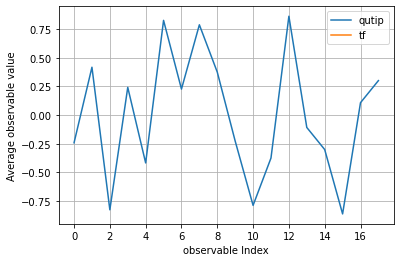

In [9]:
# plot the average expectation over all noise realizations for every observable
plt.figure()
plt.plot(np.average(expectations, 1)[0], label="qutip")
plt.plot(experiment_result["average_expectation"][0], label = "tf")
plt.ylabel("Average observable value")
plt.xlabel("observable Index")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()

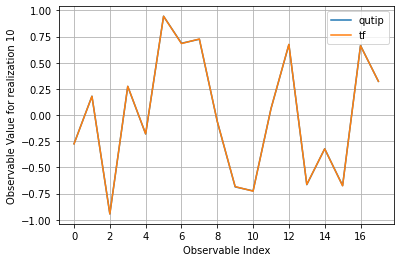

In [10]:
# plot all possible observables for a particular noise realization
idx_K = 10
plt.figure()
plt.plot(expectations[0, idx_K,:], label="qutip")
plt.plot(experiment_result["expectations"][idx_K,:],  label = "tf")
plt.ylabel("Observable Value for realization %d"%idx_K)
plt.xlabel("Observable Index")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()